# Problem Statement:

Where should WomenTechWomenYes (WTWY) locate their street teams to collect signatures and promote a gala on October 1st?

We propose to use the most recent week of MTA turnstyle data to locate subway stations with the greatest flows of people.  We will analyze this data to identify and map the best locations and times to dispatch a finite number of street teams.

More specifically, in a engineering statement, using the last four weeks of MTA turnstile data, we should be able to identify and plot the subway stations in New York with the highest flow of people for every 4 hour window in the week.

### Data Format
STATION | DAY | TIME | PEOPLE

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
import datetime
%matplotlib inline

In [2]:
#create a concated dataframe with all week's data
df1 = pd.read_csv('turnstile_180901.txt')
df2 = pd.read_csv('turnstile_180908.txt')
df3 = pd.read_csv('turnstile_180915.txt')
df4 = pd.read_csv('turnstile_180922.txt')

df_all = pd.concat([df1, df2, df3, df4])

#df1.info()
#df_all.info()


In [3]:
df=df_all 

#rename the EXITS column, which has trailing whitespace
df.columns = [column.strip() for column in df.columns]
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,REGULAR,6736067,2283184,2018-08-25 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,REGULAR,6736087,2283188,2018-08-25 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,2283229,2018-08-25 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,REGULAR,6736180,2283314,2018-08-25 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,REGULAR,6736349,2283384,2018-08-25 16:00:00


In [4]:
import collections
#THIS CODE SHOWS THAT MANY OF THE TURNSTILES COUNT REPORTS WERE RECORDED AT DIFFERNT TIMES (NOT 00:00:00)
#counted_times =  collections.Counter(df['TIME'])
#ct = []
#for k,v in counted_times.items() :
#       ct.append((k, v))
        
#ct[0:100]

#~1/2 the turnstiles are out of sync and need some time rounding. 
#from StackOverFlow

hr_4 = 4*60*60
def roundTime(ts):
    """
    The pd.to_datetime() method creates a Timestamp obj. 
    ['DATE_TIME'][0]  =>  Timestamp('2018-08-25 00:00:00')
    
    This method will take the Timestamp object from a dataframe and create the datetime object, then
    Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Orig. Author: Thierry Husson 2012 - Use it as you want but don't blame me. => modified by TR
    
    It also works on datetime objects. 
    roundTime(datetime.datetime(2012,12,31,23,44,59,1234),roundTo=60*60)
    2013-01-01 00:00:00
    """
    dt = datetime.datetime.strptime(str(ts), '%Y-%m-%d %H:%M:%S')
    
    roundTo=4*60*60
    #if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)      

#IMPORTAT SANITY CHECKS
#str(df['DATE_TIME'][0])
#datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
#.strptime(date_str, format_str)
#datetime.datetime.strptime('2018-08-25 12:00:00', '%Y-%m-%d %H:%M:%S')
#roundTime(datetime.datetime(2012,12,31,23,44,59))
#roundTime(datetime.datetime(2012,12,31,0,0,0,0))
#roundTime(datetime.datetime(2012,12,31,0,23,0,0))
#roundTime(datetime.datetime(2012,12,31,1,23,0,0))

#type(df['DATE_TIME'][0])
#df['DATE_TIME'][0]  =>  Timestamp('2018-08-25 00:00:00')
#roundTime(df['DATE_TIME'][0])




In [5]:
df['DATE_TIME_R'] = df['DATE_TIME'].apply(roundTime) 

In [6]:
df_window = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME_R"])[['ENTRIES', 'EXITS']].first().reset_index()
df_window.head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME_R,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,2018-08-25 00:00:00,6736067,2283184
1,A002,R051,02-00-00,59 ST,2018-08-25 04:00:00,6736087,2283188
2,A002,R051,02-00-00,59 ST,2018-08-25 08:00:00,6736105,2283229
3,A002,R051,02-00-00,59 ST,2018-08-25 12:00:00,6736180,2283314
4,A002,R051,02-00-00,59 ST,2018-08-25 16:00:00,6736349,2283384


In [7]:
df_window[["PREV_DATE_TIME_R", "PREV_ENTRIES", "PREV_EXITS"]] = (df_window
                                                                 .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME_R", "ENTRIES", "EXITS"]
                                                                 .transform(lambda grp: grp.shift(1)))

#df_window[["PREV_DATE_TIME_R", "PREV_ENTRIES", "PREV_EXITS"]] = (df_window
#                                                       .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME_R"])["DATE_TIME_R", "ENTRIES", "EXITS"]
#                                                       .transform(lambda grp: grp.shift(1)))

# Drop the rows for last date
df_window.dropna(subset=["PREV_DATE_TIME_R"], axis=0, inplace=True)

In [8]:
def get_net_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

def get_net_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

df_window["NET_ENTRIES"] = df_window.apply(get_net_entries, axis=1, max_counter=30000)
df_window["NET_EXITS"] = df_window.apply(get_net_exits, axis=1, max_counter=30000)

458795 3408606.0
219 211195.0
458752 15832126.0
15832652 458752.0
52 15832680.0
102 62886.0
89 15071166.0
160 663801.0
134 42404.0
82 418184.0
131074 550.0
524317 3346426.0
6 2097444.0
2097551 6.0
6 8203336.0
135 5212062.0
0 5877814.0
85 1632566.0
1048831 85.0
73 1512945.0
579 112648.0
458752 1.0
34 122767.0
0 41977.0
2 171615.0
172285 2.0
3981 1090188.0
1090864 3981.0
4372 1093229.0
1093846 4372.0
4383 1093846.0
1094472 4383.0
4796 1096618.0
1096745 4796.0
5091 1097772.0
1099189 5091.0
5167 1099189.0
1099462 5167.0
5577 1102241.0
1102565 5577.0
5881 1103940.0
1105056 5935.0
5952 1105056.0
1106522 6051.0
6165 1106847.0
1107568 6165.0
6364 1109047.0
1111172 6396.0
6638 1111172.0
1111923 6638.0
6690 1111923.0
1112083 6690.0
6765 1112083.0
1114279 6765.0
7025 1114279.0
1115012 7025.0
7082 1115012.0
1115151 7082.0
7220 1115151.0
1117287 7220.0
7441 1117287.0
1118044 7441.0
7484 1118044.0
1118169 7484.0
7681 1118169.0
1120326 7681.0
7816 1120326.0
1121034 7816.0
7879 1121034.0
1121151 7879.

In [9]:
#to get something we can actually work with, there are several more steps
#first we sum across entries and exits to get the total flow of people
df_out = df_window.groupby(['STATION', 'DATE_TIME_R'])[['NET_ENTRIES', 'NET_EXITS']].sum().reset_index()
df_out["PEOPLE"]=df_out.NET_ENTRIES+df_out.NET_EXITS

#then convert the timestamp into integers mapping to days of the weeks
#0-Monday, 1-Tuesday, etc
#and hours as ints in a 24 hour day, i.e. 4:00 PM = 16
df_out['WEEKDAY']=df_out.DATE_TIME_R.apply(lambda x: x.weekday())
df_out['HOUR']=df_out.DATE_TIME_R.apply(lambda x: x.hour)

#finally, we find the mean value across our four weeks of data
#for every four hour window on each day of the week
df_out = df_out.groupby(['STATION','WEEKDAY', 'HOUR']).PEOPLE.mean().reset_index()


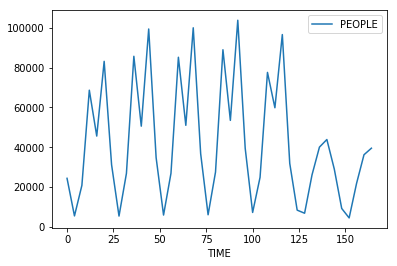

In [10]:
#quick bit of code to plot a timeseries for a station

import seaborn as sns

df_out['TIME']=df_out.WEEKDAY*24+df_out.HOUR
a =df_out[df_out.STATION=='34 ST-PENN STA']

a.plot('TIME', 'PEOPLE')

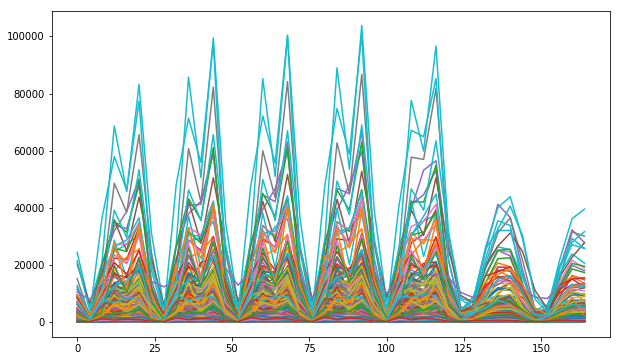

In [13]:
import matplotlib as pyplot

plt.figure(figsize=(10,6))

for station in df_out.STATION.unique():
    x =df_out[df_out.STATION==station].TIME
    y =df_out[df_out.STATION==station].PEOPLE
    plt.plot(x,y)
    

,STATION,WEEKDAY,HOUR,PEOPLE
2478,34 ST-PENN STA,0,0,24355.00
14658,TIMES SQ-42 ST,0,0,21392.00
2730,42 ST-PORT AUTH,0,0,20288.50
2394,34 ST-HERALD SQ,0,0,15167.75
9618,GRD CNTRL-42 ST,0,0,12772.75


In [149]:
#df_out.to_csv('Tidy_Benson.csv')

STATION      1 AV
WEEKDAY         0
HOUR            0
PEOPLE     4629.5
Name: 0, dtype: object

In [188]:
#we sort by PEOPLE, stations with the highest flow on top
df_out.sort_values(by='PEOPLE', ascending=False).sort_values(by=['WEEKDAY', 'HOUR'])


#small_df is the top20 stations for any given window
small_df = pd.DataFrame()
print(small_df)

for day in (range(7)):
    for hour in range(0, 24, 4):
        top20 = df_out[(df_out.WEEKDAY == day) & (df_out.HOUR == hour)].sort_values(by='PEOPLE', ascending=False)[0:20]
        small_df= pd.concat([small_df, top20])

small_df.head()
small_df.to_csv('Top20_Benson.csv')

Empty DataFrame
Columns: []
Index: []


In [153]:
list(range(0, 24, 4))

[0, 4, 8, 12, 16, 20]

In [189]:
for item in small_df.STATION.unique():
    print(item)

34 ST-PENN STA
TIMES SQ-42 ST
42 ST-PORT AUTH
34 ST-HERALD SQ
GRD CNTRL-42 ST
125 ST
14 ST-UNION SQ
JOURNAL SQUARE
PATH NEW WTC
FLUSHING-MAIN
59 ST COLUMBUS
FULTON ST
JKSN HT-ROOSVLT
CANAL ST
23 ST
86 ST
50 ST
59 ST
14 ST
W 4 ST-WASH SQ
145 ST
JAMAICA CENTER
JUNCTION BLVD
96 ST
7 AV
72 ST
47-50 STS ROCK
CHAMBERS ST
LEXINGTON AV/53
WALL ST
ATL AV-BARCLAY
KEW GARDENS
METS-WILLETS PT
72 ST-2 AVE
42 ST-BRYANT PK
5 AV/53 ST
GROVE STREET
CITY / BUS
161/YANKEE STAD
CHURCH AV
JAY ST-METROTEC
BEDFORD AV


In [190]:
small_df.PEOPLE.max()

103837.5

In [191]:
df_out.PEOPLE.max()

103837.5

In [8]:
df_window['34 ST-PENN STA']

NameError: name 'df_window' is not defined